# Ghouls, Goblins, and Ghosts... Boo!

This is a fun Halloween competition. We have some characteristics of monsters and the goal is to predict the type of monsters: ghouls, goblins or ghosts.

At first I do data exploration to get some insights. Then I try various models for prediction.

1. [Data exploration](#datex)

2. [Data preparation](#datprep)

3. [Model](#model)

In [1]:
#Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn import svm

## <a name="datex">Data exploration</a>

In [2]:
#Reading data
#train = pd.read_csv('../input/train.csv')
#test = pd.read_csv('../input/test.csv')
train = pd.read_csv('d:/_python/Python projects/Kaggle/Data_Kaggle/Ghouls, Goblins, and Ghosts/train.csv')
test = pd.read_csv('d:/_python/Python projects/Kaggle/Data_Kaggle/Ghouls, Goblins, and Ghosts/test.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371 entries, 0 to 370
Data columns (total 7 columns):
id               371 non-null int64
bone_length      371 non-null float64
rotting_flesh    371 non-null float64
hair_length      371 non-null float64
has_soul         371 non-null float64
color            371 non-null object
type             371 non-null object
dtypes: float64(4), int64(1), object(2)
memory usage: 20.4+ KB


So there are 4 numerical variables and 1 categorical. And no missing values, which is nice!

In [4]:
train.describe(include='all')

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
count,371.000000,371.000000,371.000000,371.000000,371.000000,371,371
unique,NaN,NaN,NaN,NaN,NaN,6,3
top,NaN,NaN,NaN,NaN,NaN,white,Ghoul
freq,NaN,NaN,NaN,NaN,NaN,137,129
mean,443.676550,0.434160,0.506848,0.529114,0.471392,NaN,NaN
std,263.222489,0.132833,0.146358,0.169902,0.176129,NaN,NaN
min,0.000000,0.061032,0.095687,0.134600,0.009402,NaN,NaN
25%,205.500000,0.340006,0.414812,0.407428,0.348002,NaN,NaN
50%,458.000000,0.434891,0.501552,0.538642,0.466372,NaN,NaN
75%,678.500000,0.517223,0.603977,0.647244,0.600610,NaN,NaN


Numerical columns are either normalized or show a percentage, so no need to scale them.

In [5]:
train.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,1,0.575560,0.425868,0.531401,0.439899,green,Goblin
2,2,0.467875,0.354330,0.811616,0.791225,black,Ghoul
3,4,0.776652,0.508723,0.636766,0.884464,black,Ghoul
4,5,0.566117,0.875862,0.418594,0.636438,green,Ghost


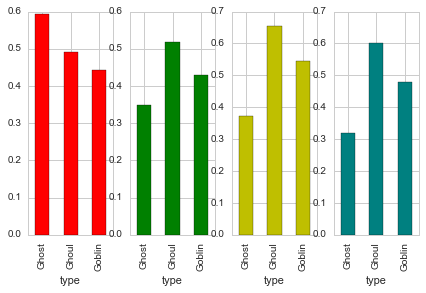

In [6]:
plt.subplot(1,4,1)
train.groupby('type').mean()['rotting_flesh'].plot(kind='bar',figsize=(7,4), color='r')
plt.subplot(1,4,2)
train.groupby('type').mean()['bone_length'].plot(kind='bar',figsize=(7,4), color='g')
plt.subplot(1,4,3)
train.groupby('type').mean()['hair_length'].plot(kind='bar',figsize=(7,4), color='y')
plt.subplot(1,4,4)
train.groupby('type').mean()['has_soul'].plot(kind='bar',figsize=(7,4), color='teal')

It seems that all numerical features may be useful.

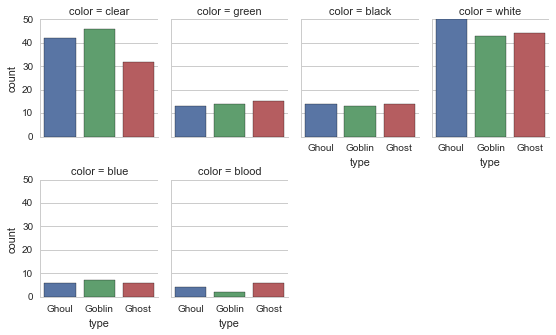

In [7]:
sns.factorplot("type", col="color", col_wrap=4, data=train, kind="count", size=2.4, aspect=.8)

Funny, but many colors are evenly distributes among the monsters. So they maybe nor very useful for analysis.

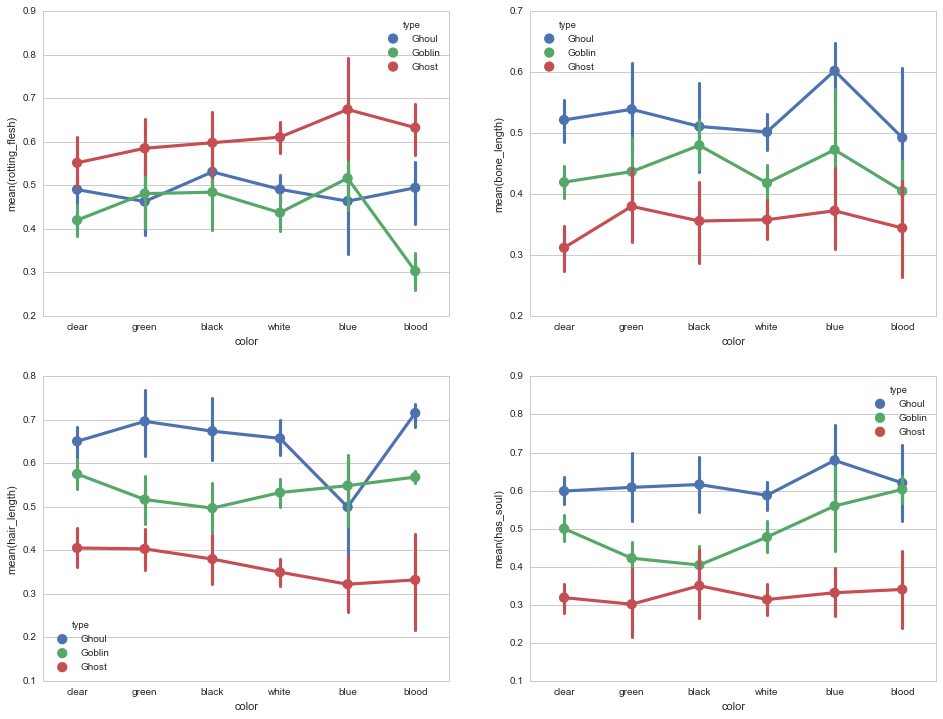

In [8]:
fig, ax = plt.subplots(2, 2, figsize = (16, 12))
sns.pointplot(x="color", y="rotting_flesh", hue="type", data=train, ax = ax[0, 0])
sns.pointplot(x="color", y="bone_length", hue="type", data=train, ax = ax[0, 1])
sns.pointplot(x="color", y="hair_length", hue="type", data=train, ax = ax[1, 0])
sns.pointplot(x="color", y="has_soul", hue="type", data=train, ax = ax[1, 1])

In most cases color won't "help" other variables to improve accuracy.

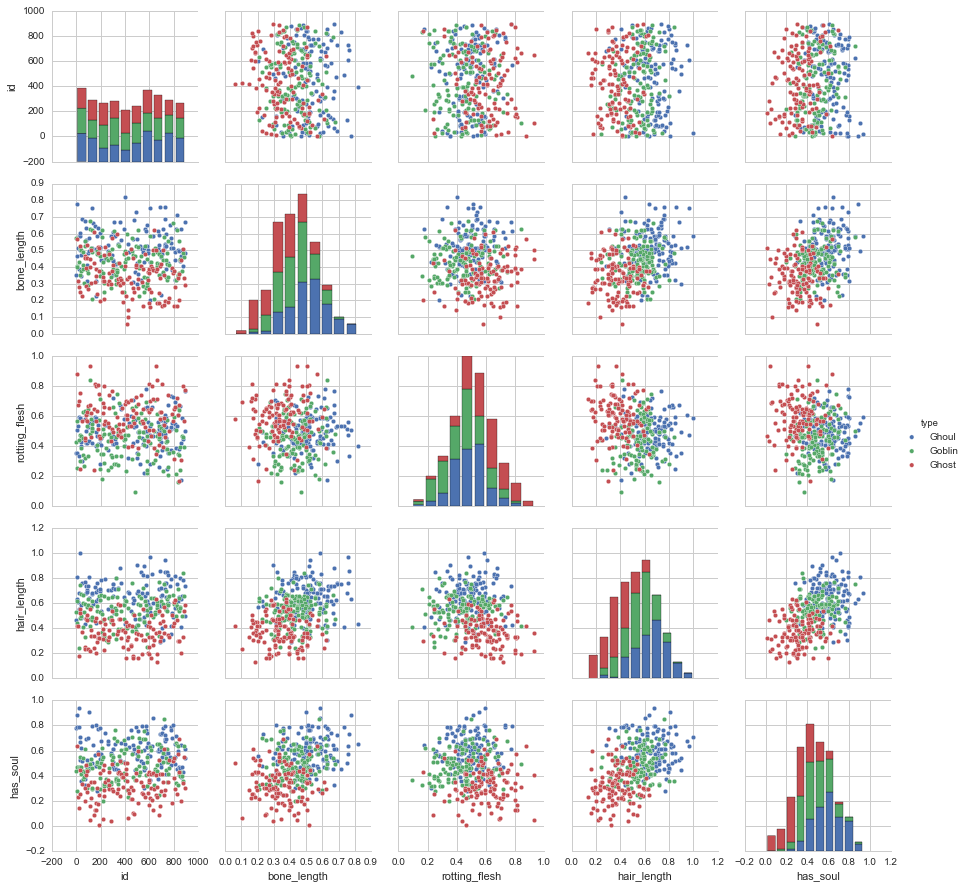

In [9]:
sns.pairplot(train, hue='type')

This pairplot shows that data is distributed normally. And while most pairs are widely scattered (in relationship to the type), some of them show clusters: hair_length and has_soul, hair_length and bone_length. I decided to create new variables with multiplication of these columns and it worked great!

## <a name="datprep">Data preparation</a>

In [10]:
train['hair_soul'] = train['hair_length'] * train['has_soul']
train['hair_bone'] = train['hair_length'] * train['bone_length']
test['hair_soul'] = test['hair_length'] * test['has_soul']
test['hair_bone'] = test['hair_length'] * test['bone_length']
train['hair_soul_bone'] = train['hair_length'] * train['has_soul'] * train['bone_length']
test['hair_soul_bone'] = test['hair_length'] * test['has_soul'] * test['bone_length']

In [11]:
#test_id will be used later, so save it
test_id = test['id']
train.drop(['id'], axis=1, inplace=True)
test.drop(['id'], axis=1, inplace=True)

In [12]:
#Dummify 'color' column.
col = 'color'
dummies = pd.get_dummies(train[col], drop_first=False)
dummies = dummies.add_prefix("{}_".format(col))
train.drop(col, axis=1, inplace=True)
train = train.join(dummies)
dummies = pd.get_dummies(test[col], drop_first=False)
dummies = dummies.add_prefix("{}_".format(col))
test.drop(col, axis=1, inplace=True)
test = test.join(dummies)

In [13]:
#Data for modelling
X_train = train.drop('type', axis=1)
le = LabelEncoder()
Y_train = le.fit_transform(train.type.values)
X_test = test

In [14]:
clf = RandomForestClassifier(n_estimators=200)
clf = clf.fit(X_train, Y_train)
indices = np.argsort(clf.feature_importances_)[::-1]

# Print the feature ranking
print('Feature ranking:')

for f in range(X_train.shape[1]):
    print('%d. feature %d %s (%f)' % (f + 1, indices[f], X_train.columns[indices[f]],
                                      clf.feature_importances_[indices[f]]))

Feature ranking:
1. feature 6 hair_soul_bone (0.195487)
2. feature 4 hair_soul (0.171702)
3. feature 5 hair_bone (0.141787)
4. feature 3 has_soul (0.126128)
5. feature 2 hair_length (0.119067)
6. feature 1 rotting_flesh (0.118509)
7. feature 0 bone_length (0.085827)
8. feature 12 color_white (0.009954)
9. feature 10 color_clear (0.008961)
10. feature 11 color_green (0.007131)
11. feature 7 color_black (0.006712)
12. feature 9 color_blue (0.006499)
13. feature 8 color_blood (0.002237)


Graphs and model show that color has little impact, so I won't use it. In fact I tried using it, but the result got worse.
And three features, which I created, seem to be important!

In [15]:
best_features=X_train.columns[indices[0:7]]
X = X_train[best_features]
Xt = X_test[best_features]

## <a name="model">Model</a>

In [16]:
#Splitting data for validation
Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y_train, test_size=0.20, random_state=36)

Tune the model. Normally you input all parameters and their potential values and run GridSearchCV. My PC isn't good enough so I divide parameters in two groups and repeatedly run two GridSearchCV until I'm satisfied with the result. This gives a balance between the quality and the speed.

In [17]:
forest = RandomForestClassifier(max_depth = 100,                                
                                min_samples_split =2,
                                min_weight_fraction_leaf = 0.0,
                                max_leaf_nodes = 40)

parameter_grid = {'n_estimators' : [10, 20, 150],
                  'criterion' : ['gini', 'entropy'],
                  'max_features' : ['auto', 'sqrt', 'log2']
                 }

grid_search = GridSearchCV(forest, param_grid=parameter_grid, scoring='accuracy', cv=StratifiedKFold(5))
grid_search.fit(X, Y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.7142857142857143
Best parameters: {'n_estimators': 10, 'max_features': 'auto', 'criterion': 'entropy'}


In [18]:
forest = RandomForestClassifier(n_estimators = 20,
                                criterion = 'entropy',
                                max_features = 'sqrt')
parameter_grid = {
                  'max_depth' : [None, 5, 100],
                  'min_samples_split' : [2, 5, 7],
                  'min_weight_fraction_leaf' : [0.0, 0.1],
                  'max_leaf_nodes' : [40, 80],
                 }

grid_search = GridSearchCV(forest, param_grid=parameter_grid, scoring='accuracy', cv=StratifiedKFold(5))
grid_search.fit(X, Y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.7304582210242587
Best parameters: {'max_depth': None, 'min_weight_fraction_leaf': 0.1, 'max_leaf_nodes': 80, 'min_samples_split': 5}


Calibrated classifier gives probabilities for each class, so to check the accuracy at first I chose the most probable class and convert it to values. Then I compare it to values of validation set.

In [19]:
#Optimal parameters
clf = RandomForestClassifier(n_estimators=20, n_jobs=-1, criterion = 'gini', max_features = 'sqrt',
                             min_samples_split=2, min_weight_fraction_leaf=0.0,
                             max_leaf_nodes=40, max_depth=100)
#Calibration improves probability predictions
calibrated_clf = CalibratedClassifierCV(clf, method='sigmoid', cv=5)
calibrated_clf.fit(Xtrain, ytrain)
y_val = calibrated_clf.predict_proba(Xtest)

print("Validation accuracy: ", sum(pd.DataFrame(y_val, columns=le.classes_).idxmax(axis=1).values
                                   == le.inverse_transform(ytest))/len(ytest))

Validation accuracy:  0.72


I used the best parameters and validation accuracy is ~68-72%. Not bad. But let's try something else.

In [20]:
svc = svm.SVC(kernel='linear')
svc.fit(Xtrain, ytrain)
y_val_s = svc.predict(Xtest)
print("Validation accuracy: ", sum(le.inverse_transform(y_val_s) == le.inverse_transform(ytest))/len(ytest))

Validation accuracy:  0.76


Much better! Usually RandomForest requires a lot of data for good performance. It seems that in this case there was too little data for it.

In [21]:
#The last model is logistic regression
logreg = LogisticRegression()

parameter_grid = {'solver' : ['newton-cg', 'lbfgs'],
                  'multi_class' : ['ovr', 'multinomial'],
                  'C' : [0.005, 0.01, 1, 10, 100, 1000],
                  'tol': [0.0001, 0.001, 0.005]
                 }

grid_search = GridSearchCV(logreg, param_grid=parameter_grid, cv=StratifiedKFold(5))
grid_search.fit(Xtrain, ytrain)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.75
Best parameters: {'solver': 'newton-cg', 'C': 1, 'tol': 0.0001, 'multi_class': 'multinomial'}


In [22]:
log_reg = LogisticRegression(C = 1, tol = 0.0001, solver='newton-cg', multi_class='multinomial')
log_reg.fit(Xtrain, ytrain)
y_val_l = log_reg.predict_proba(Xtest)
print("Validation accuracy: ", sum(pd.DataFrame(y_val_l, columns=le.classes_).idxmax(axis=1).values
                                   == le.inverse_transform(ytest))/len(ytest))

Validation accuracy:  0.773333333333


It seems that regression is better. The reason? As far as I understand, the algorithms are similar, but with different loss function. And most importantly: SVC is a hard classifier while LR gives probabilities.

In [23]:
#So this is it. Now fit and model on full dataset
log_reg.fit(X, Y_train)
y_pred = log_reg.predict_proba(Xt)

In [24]:
submission = pd.DataFrame({'id':test_id, 'type':pd.DataFrame(y_pred, columns=le.classes_).idxmax(axis=1).values})
submission.to_csv('GGG_submission1.csv', index=False)

The competition has started some time ago. My model got 0.73346, which was at top 10% at that moment. Currently top accuracy is 0.74858.